In [1]:
import csv
import torch, argparse
import autograd.numpy as np
import autograd
import os
from scipy.stats import norm
from utils import leapfrog, to_pickle, from_pickle
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm
from scipy.stats import uniform

2025-01-09 15:26:00.304034: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 15:26:00.312139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736407560.321595   21001 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736407560.324481   21001 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 15:26:00.335184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
input_dim = 2
len_sample = 20
num_samples = 20
test_fraction = 0
timescale = 0.05

In [3]:
def H(coords):
    #coords = [q,p] in R2
    q, p = np.split(coords,2)
    mu1 = 1.0
    mu2 =-1.0
    sigma = 0.35
    term1 = -np.log(0.5*(np.exp(-(q-mu1)**2/(2*sigma**2)))+0.5*(np.exp(-(q-mu2)**2/(2*sigma**2))))
    H_val = term1 + p**2/2 # Normal PDF
    return H_val 

In [4]:
def dynamics_fn(t, coords):
    dcoords = autograd.grad(H)(coords)
    dic1 = np.split(dcoords,input_dim)
    S = np.concatenate([dic1[int(input_dim/2)]])
    for ii in np.arange(int(input_dim/2)+1,input_dim,1):
        S = np.concatenate([S, dic1[ii]])
    for ii in np.arange(0,int(input_dim/2),1):
        S = np.concatenate([S, -dic1[ii]])
    return S

def get_trajectory(t_span=[0,len_sample], timescale=timescale, y0=None, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1]-t_span[0])/timescale))

    if y0 is None:
        y0 = np.zeros(input_dim)
        for ii in np.arange(0,int(input_dim/2),1):
            y0[ii] = norm(loc=0,scale=1).rvs()
    #lp_ivp = leapfrog(dynamics_fn, t_span, y0,int(timescale*(t_span[1]-t_span[0])), input_dim)
    lp_ivp = leapfrog(dynamics_fn, t_span, y0,int((t_span[1]-t_span[0])/timescale), input_dim)
    dic1 = np.split(lp_ivp, input_dim)
    dydt = [dynamics_fn(None, lp_ivp[:,ii]) for ii in range(0, lp_ivp.shape[1])]
    dydt = np.stack(dydt).T
    ddic1 = np.split(dydt, input_dim)
    return dic1, ddic1, t_eval

In [5]:
def get_dataset(seed=0, samples=num_samples, test_split=(1.0-test_fraction), **kwargs):
    data = {'meta': locals()}
    # randomly sample inputs
    np.random.seed(seed) #
    xs, dxs = [], []
    index1 = 0

    count1 = 0
    y_init = np.zeros(input_dim)
    for ii in np.arange(0,int(input_dim/2),1):
        y_init[ii] = 0.0
    for ii in np.arange(int(input_dim/2),input_dim,1):
        y_init[ii] = norm(loc=0,scale=1).rvs()

    print('Generating HMC samples for HNN training')

    for s in range(samples):
        print('Sample number ' + str(s+1) + ' of ' + str(samples))
        dic1, ddic1, t = get_trajectory(y0=y_init,**kwargs)
        xs.append(np.stack( [dic1[ii].T.reshape(len(dic1[ii].T)) for ii in np.arange(0,input_dim,1)]).T)
        dxs.append(np.stack( [ddic1[ii].T.reshape(len(ddic1[ii].T)) for ii in np.arange(0,input_dim,1)]).T)
        y_init = np.zeros(input_dim)
        count1 = count1 + 1
        #print(dic1[0].shape)
        for ii in np.arange(0,int(input_dim/2),1):
            y_init[ii] = dic1[ii][0,-1]
        for ii in np.arange(int(input_dim/2),input_dim,1):
            y_init[ii] = norm(loc=0,scale=1).rvs()

    data['coords'] = np.concatenate(xs)
    data['dcoords'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['coords']) * test_split)
    split_data = {}
    for k in ['coords', 'dcoords']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data

    # save data
    path = "./data"
    if not os.path.exists(path):
        os.makedirs(path)
    to_pickle(data, path+"/{}.pkl".format("1DGaussian"))

    return data

In [6]:
dat = get_dataset()

Generating HMC samples for HNN training
Sample number 1 of 20
Sample number 2 of 20
Sample number 3 of 20
Sample number 4 of 20
Sample number 5 of 20
Sample number 6 of 20
Sample number 7 of 20
Sample number 8 of 20
Sample number 9 of 20
Sample number 10 of 20
Sample number 11 of 20
Sample number 12 of 20
Sample number 13 of 20
Sample number 14 of 20
Sample number 15 of 20
Sample number 16 of 20
Sample number 17 of 20
Sample number 18 of 20
Sample number 19 of 20
Sample number 20 of 20


In [7]:
dat['coords'].shape,dat['dcoords'].shape

((8020, 2), (8020, 2))

In [8]:
dat["dcoords"]

array([[ 1.76405235, -0.        ],
       [ 1.87195437,  4.31608098],
       [ 2.12738862,  5.90128914],
       ...,
       [-1.26356053, -2.97798555],
       [-1.39881515, -2.43219933],
       [-1.50553403, -1.83655565]])

In [9]:
import matplotlib.pyplot as plt 

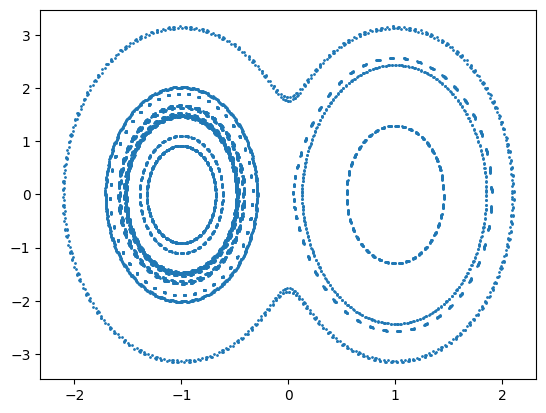

In [10]:
plt.scatter(dat['coords'][:,0],dat['coords'][:,1],s=1)

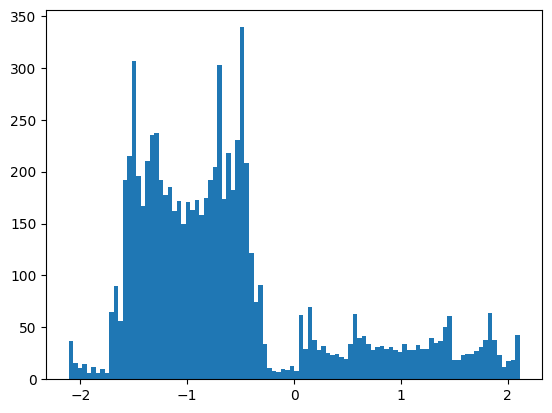

In [11]:
plt.hist(dat['coords'][:,0],bins=25)
plt.show()

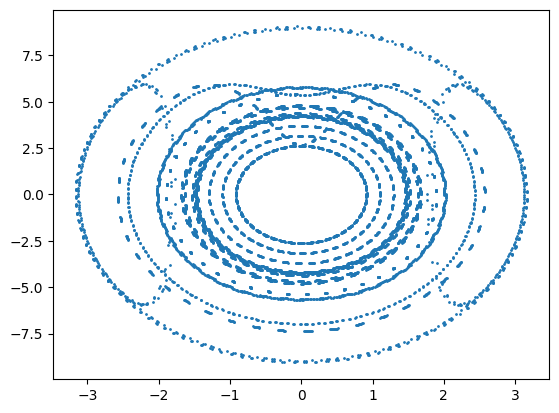

In [12]:
plt.scatter(dat['dcoords'][:,0],dat['dcoords'][:,1],s=1)

In [13]:
chains = 1 # number of Markov chains
N = 5000 # number of samples   
L = 10 # length of each hamiltonian trajectory
burn = 1000 # burn-in samples
epsilon = 0.025 # step for time integration

In [14]:
def integrate_model(model, t_span, y0, n, **kwargs):
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,input_dim)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx
    return leapfrog(fun, t_span, y0, n, input_dim)

In [15]:
steps = L*int(1/epsilon)
t_span = [0,L]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], steps), 'rtol': 1e-10}
hnn_fin = np.zeros((chains,N,int(input_dim/2)))
hnn_accept = np.zeros((chains,N))

y0 = np.zeros(input_dim)
for ss in np.arange(0,chains,1):
    x_req = np.zeros((N,int(input_dim/2)))
    x_req[0,:] = y0[0:int(input_dim/2)]
    accept = np.zeros(N)
    
    for ii in np.arange(0,int(input_dim/2),1):
        y0[ii] = 0.0
    for ii in np.arange(int(input_dim/2),int(input_dim),1):
        y0[ii] = norm(loc=0,scale=1).rvs()
    HNN_sto = np.zeros((input_dim,steps,N))
    for ii in np.arange(0,N,1):
        #hnn_ivp = integrate_model(H, t_span, y0, steps-1, **kwargs)
        hnn_ivp = leapfrog(dynamics_fn, t_span, y0, steps-1, input_dim)
        for sss in range(0,input_dim):
            HNN_sto[sss,:,ii] = hnn_ivp[sss,:]
        yhamil = np.zeros(input_dim)
        for jj in np.arange(0,input_dim,1):
            yhamil[jj] = hnn_ivp[jj,steps-1]
        H_star = H(yhamil)
        H_prev = H(y0)
        alpha = np.minimum(1,np.exp(H_prev - H_star))
        if alpha > uniform().rvs():
            y0[0:int(input_dim/2)] = hnn_ivp[0:int(input_dim/2),steps-1]
            x_req[ii,:] = hnn_ivp[0:int(input_dim/2),steps-1]
            accept[ii] = 1
        else:
            x_req[ii,:] = y0[0:int(input_dim/2)]
        for jj in np.arange(int(input_dim/2),input_dim,1):
            y0[jj] = norm(loc=0,scale=1).rvs()
        print("Sample: "+str(ii)+" Chain: "+str(ss))
    hnn_accept[ss,:] = accept
    hnn_fin[ss,:,:] = x_req

ess_hnn = np.zeros((chains,int(input_dim/2)))
for ss in np.arange(0,chains,1):
    hnn_tf = tf.convert_to_tensor(hnn_fin[ss,burn:N,:])
    ess_hnn[ss,:] = np.array(tfp.mcmc.effective_sample_size(hnn_tf))

Sample: 0 Chain: 0
Sample: 1 Chain: 0
Sample: 2 Chain: 0
Sample: 3 Chain: 0
Sample: 4 Chain: 0
Sample: 5 Chain: 0
Sample: 6 Chain: 0
Sample: 7 Chain: 0
Sample: 8 Chain: 0
Sample: 9 Chain: 0
Sample: 10 Chain: 0
Sample: 11 Chain: 0
Sample: 12 Chain: 0
Sample: 13 Chain: 0
Sample: 14 Chain: 0
Sample: 15 Chain: 0
Sample: 16 Chain: 0
Sample: 17 Chain: 0
Sample: 18 Chain: 0
Sample: 19 Chain: 0
Sample: 20 Chain: 0
Sample: 21 Chain: 0
Sample: 22 Chain: 0
Sample: 23 Chain: 0
Sample: 24 Chain: 0
Sample: 25 Chain: 0
Sample: 26 Chain: 0
Sample: 27 Chain: 0
Sample: 28 Chain: 0
Sample: 29 Chain: 0
Sample: 30 Chain: 0
Sample: 31 Chain: 0
Sample: 32 Chain: 0
Sample: 33 Chain: 0
Sample: 34 Chain: 0
Sample: 35 Chain: 0
Sample: 36 Chain: 0
Sample: 37 Chain: 0
Sample: 38 Chain: 0
Sample: 39 Chain: 0
Sample: 40 Chain: 0
Sample: 41 Chain: 0
Sample: 42 Chain: 0
Sample: 43 Chain: 0
Sample: 44 Chain: 0
Sample: 45 Chain: 0
Sample: 46 Chain: 0
Sample: 47 Chain: 0
Sample: 48 Chain: 0
Sample: 49 Chain: 0
Sample: 50

I0000 00:00:1736408049.334474   21001 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


W0000 00:00:1736408050.328483   21001 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/dual/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/dual/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/dual/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
W0000 00:00:1736408050.333533   21001 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Fall

In [16]:
for ss in np.arange(0,chains,1):
    subdat = hnn_fin[ss,burn:N,:]
    subacc = hnn_accept[ss,burn:N]

    accpt = subdat[subacc==1,:]
    

In [17]:
accpt.shape 

(3999, 1)

(array([  8.,  38.,  85., 196., 313., 356., 387., 305., 212.,  93.,  40.,
          9.,  12.,  63., 111., 209., 333., 369., 351., 258., 144.,  77.,
         18.,   8.,   4.]),
 array([-2.04138382, -1.86942553, -1.69746723, -1.52550894, -1.35355065,
        -1.18159235, -1.00963406, -0.83767577, -0.66571748, -0.49375918,
        -0.32180089, -0.1498426 ,  0.0221157 ,  0.19407399,  0.36603228,
         0.53799057,  0.70994887,  0.88190716,  1.05386545,  1.22582375,
         1.39778204,  1.56974033,  1.74169863,  1.91365692,  2.08561521,
         2.2575735 ]),
 <BarContainer object of 25 artists>)

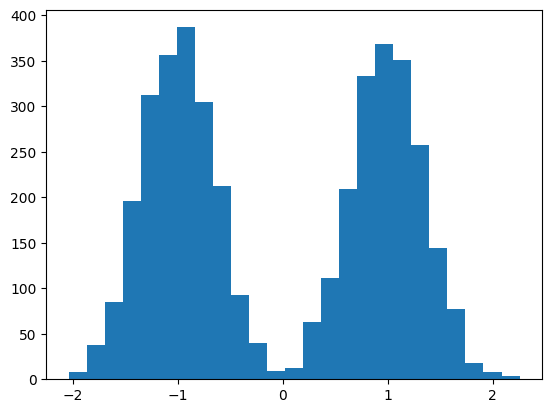

In [19]:
plt.hist(accpt,bins=25)